In [21]:
import keras
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)
import numpy as np
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import json

TensorFlow version:  2.4.1


# Dataset Prep

In [3]:
# initialize the empty list of image file paths
images = []

## add images from the single object dataset
# path to single spam images
data_dir = "./data/fat/single/010_potted_meat_can_16k/"
data_dir = pathlib.Path(data_dir) # makes sure the path is appropriate for the system

# loop over each subdirectory and add the .jpg spam images to the image list
for dir in data_dir.glob("./*"):    
    images = images + list(dir.glob("*.jpg"))
    
## add images from the mixed dataset
# path to mixed images
data_dir = "./data/fat/mixed/"
data_dir = pathlib.Path(data_dir)

# loop over each subdirectory and add the .jpg images to the list
for dir in data_dir.glob("./*"):
    images = images + list(dir.glob("*.jpg"))

# image params
img_height = 540
img_width = 960
image_count = len(images)
batch_size = 32

## JSON prep
json_files = [str(img_path)[0:-3] + "json" for img_path in images]

## print image count
print("total images: " + str(image_count))

total images: 63000


## Dataset Visualization and Testing

data/fat/mixed/kitchen_3/001399.right.jpg
None
[{'name': 'left', 'horizontal_fov': 64, 'intrinsic_settings': {'fx': 768.1605834960938, 'fy': 768.1605834960938, 'cx': 480, 'cy': 270, 's': 0}, 'captured_image_size': {'width': 960, 'height': 540}}, {'name': 'right', 'horizontal_fov': 64, 'intrinsic_settings': {'fx': 768.1605834960938, 'fy': 768.1605834960938, 'cx': 480, 'cy': 270, 's': 0}, 'captured_image_size': {'width': 960, 'height': 540}}]
Pose Transform Raw:
[[  0.44510001   0.50840002   0.73710001   0.        ]
 [ -0.5927       0.78430003  -0.1831       0.        ]
 [  0.67119998   0.3554      -0.6505       0.        ]
 [-13.04100037  -6.34520006  69.08750153   1.        ]]
Pose Transform Edited:
[[ -0.5927      -0.67119998   0.44510001 -13.04100037]
 [  0.78430003  -0.3554       0.50840002  -6.34520006]
 [ -0.1831       0.6505       0.73710001  69.08750153]
 [  0.           0.           0.           1.        ]]


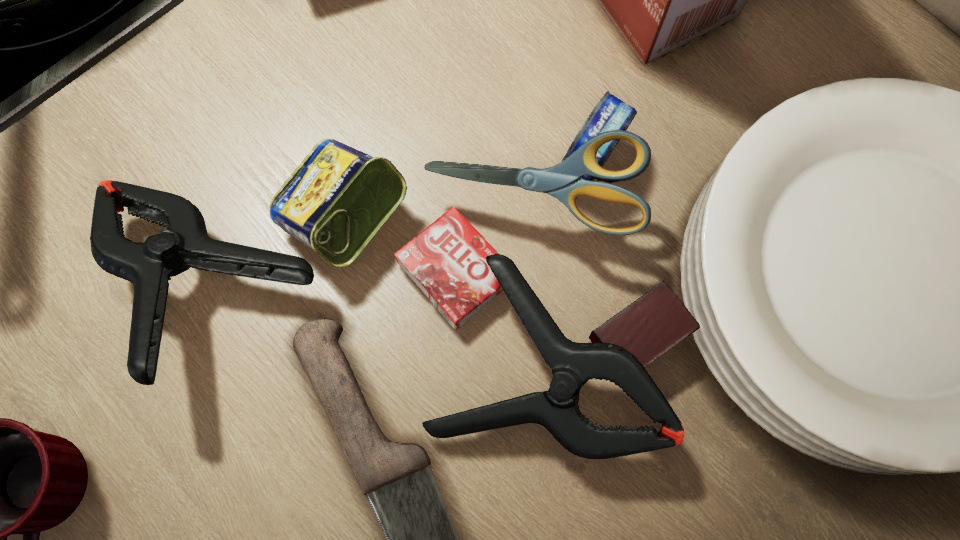

In [125]:
# select image to display
image_number = 4000
print(str(images[image_number]))

# open json file
with open(json_files[image_number], "r") as read_file:
    data = json.load(read_file)

# 
P = np.array([
    [0, 0, 1, 0],
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, 0, 1]
])
object_of_interest = "010_potted_meat_can_16k"
keypoints_2d = [None]
print(keypoints_2d[-1])

# camera data
camera_settings_dir = "./data/fat/single/010_potted_meat_can_16k/kitchen_0/_camera_settings.json" 
camera_settings_dir = pathlib.Path(camera_settings_dir)
with open(camera_settings_dir, "r") as read_file:
    camera_data = json.load(read_file)
# print(data["camera_data"])
# print(camera_data.keys())
print(camera_data["camera_settings"])

# object data
for object in range(len(data["objects"])):
    # get the class of the object
    obj_class = data["objects"][object]["class"]
    
    if data["objects"][object]["class"] == object_of_interest:
        # extract the 4x4 homogenous transformation matrix
        print("Pose Transform Raw:")
        A = np.array(data["objects"][object]["pose_transform_permuted"])
        print(A)
        print("Pose Transform Edited:")
        print(A.T.dot(P))
        
        
        # used to train the CNN and test solvePnPRansac before the CNN has been trained
        keypoints_2d[-1] = data["objects"][object]["projected_cuboid"]
        # used to train the CNN and test solvePnPRansac before the CNN has been trained
        keypoints_2d[-1].append(data["objects"][object]["projected_cuboid_centroid"])
        # This is used to input to solvePnPRansac as a test of that function's implementation before the CNN has been trained.
        data["objects"][object]["cuboid_centroid"]
        # This is used to input to solvePnPRansac as a test of that function's implementation before the CNN has been trained.
        data["objects"][object]["cuboid"]
        
# print(data["objects"])
shifted_keypoints = []
shift = 500
for keypoint in keypoints_2d[0]:
    shifted_keypoints.append([keypoint[0] + 500, keypoint[1]])
keypoints_2d.append(shifted_keypoints)
# print(keypoints_2d)
# print(len(keypoints_2d))


# display the image
image = PIL.Image.open(str(images[image_number])) 
display(image)

# Belief Maps

In [126]:
def CreateBeliefMap(img,keypoints_2d,nbpoints,sigma=16):
    """
    Input: 
        img: image
        keypoints_2d: list of 2D keypoint in the form for all objects as a 3D list
            where len(keypoints_2d) = number of object instances; this level is a list for each object instance
            len(keypoints_2d[0]) = nbpoints; this level is a list of keypoints
            len(keypoints_2d[0][0]) = 2; this level is [x,y] points that make up each keypoint
        nbpoints: (int) number of points, DOPE uses 9 points here (eight cuboid points plus one cuboid centroid)
        sigma: (int) standard deviation of the Gaussian used to calculate belief map pixel values for each keypoint
            -> determines the size of the belief map point
    return: 
        beliefsImg: an array of PIL black and white images representing the belief maps         
    """
    beliefsImg = []
    sigma = int(sigma)
    numInstances = len(keypoints_2d)
    
    # loop over each point index (e.g. 9 loop iterations for 9 points)
    for numb_point in range(nbpoints):    
        array = np.zeros(img.size)
        out = np.zeros(img.size)

        # loop over every object instance and add all keypoints with index=numb_point to this image 
        # e.g. an object that appears twice in the frame will display two keypoint #2 belief
        # regions at image #2 returned in beliefsImg
        for object_instance in range(len(keypoints_2d)):
            p = keypoints_2d[object_instance][numb_point] # the keypoint for this object
            w = int(sigma*2) # the 2 sigma bound

            # first check that the 2 sigma bounds are within the image width and height boundaries
            if p[0]-w>=0 and p[0]+w<img.size[0] and p[1]-w>=0 and p[1]+w<img.size[1]:
                
                # double for loop to iterate over 2 sigma bounds in x and y and populate belief 
                # pixel values to indicate the keypoint's presence at that 2d location
                for i in range(int(p[0])-w, int(p[0])+w):
                    for j in range(int(p[1])-w, int(p[1])+w):
                        # populate belief values for each pixel with Gaussian distribution
                        array[i,j] = np.exp(-(((i - p[0])**2 + (j - p[1])**2)/(2*(sigma**2))))

        # add this keypoint layer to the belief map output
        stack = np.stack([array,array,array],axis=0).transpose(2,1,0)
        imgBelief = Image.new(img.mode, img.size, "black")
        beliefsImg.append(Image.fromarray((stack*255).astype('uint8')))
    return beliefsImg

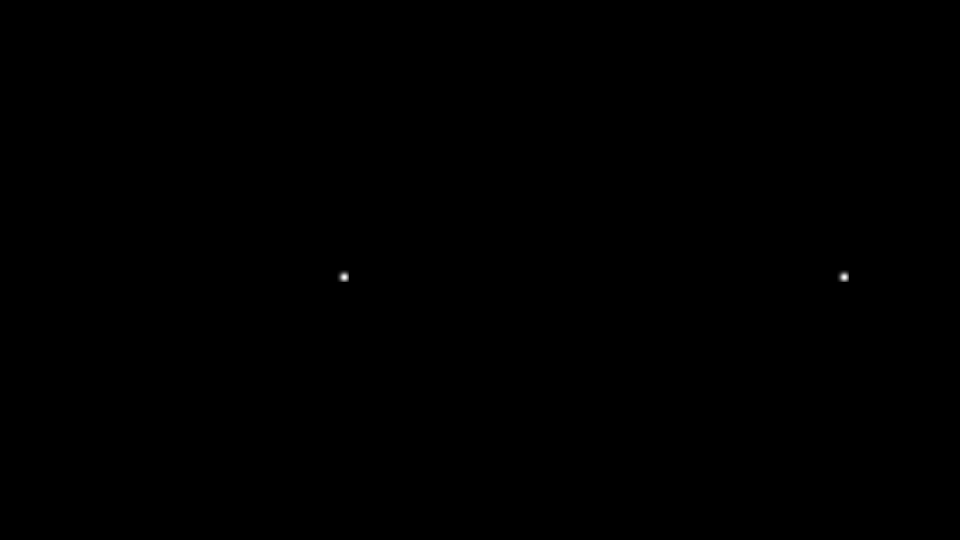

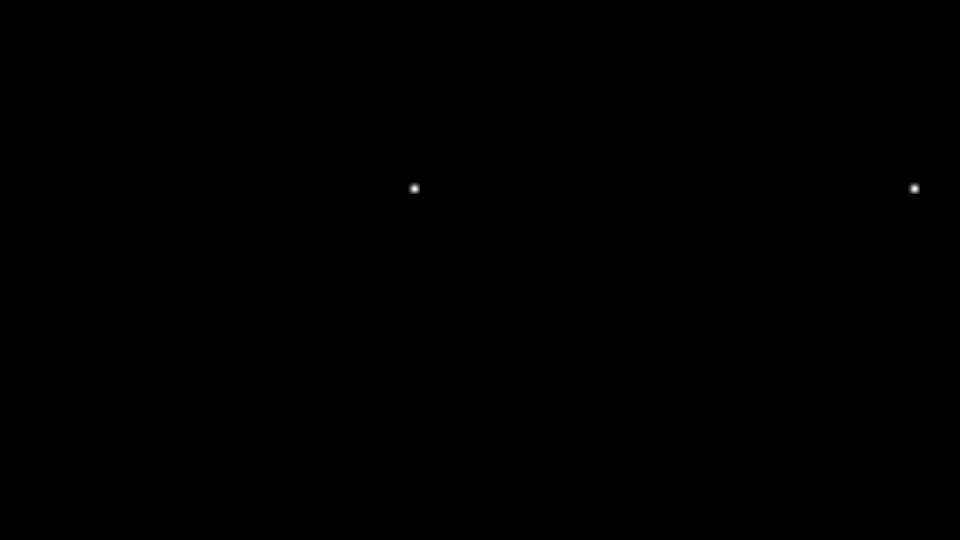

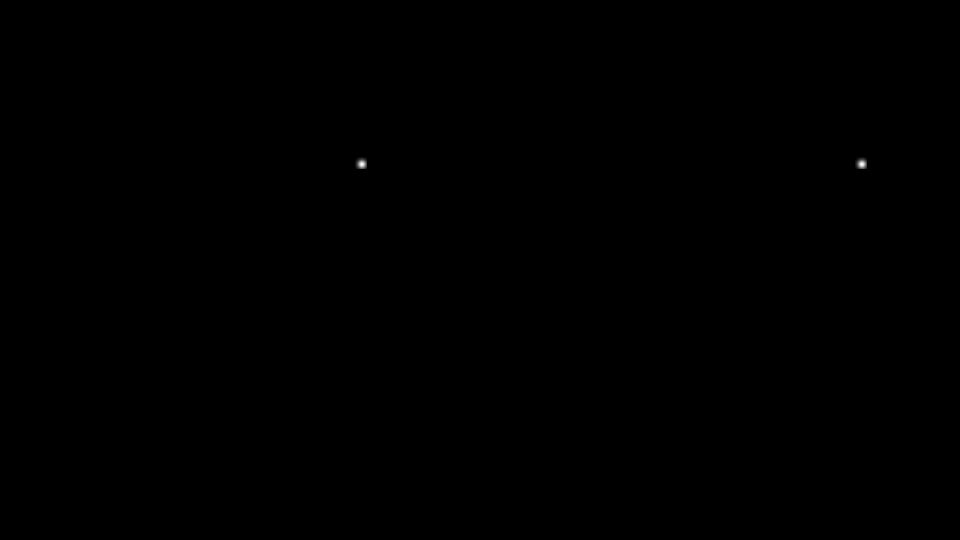

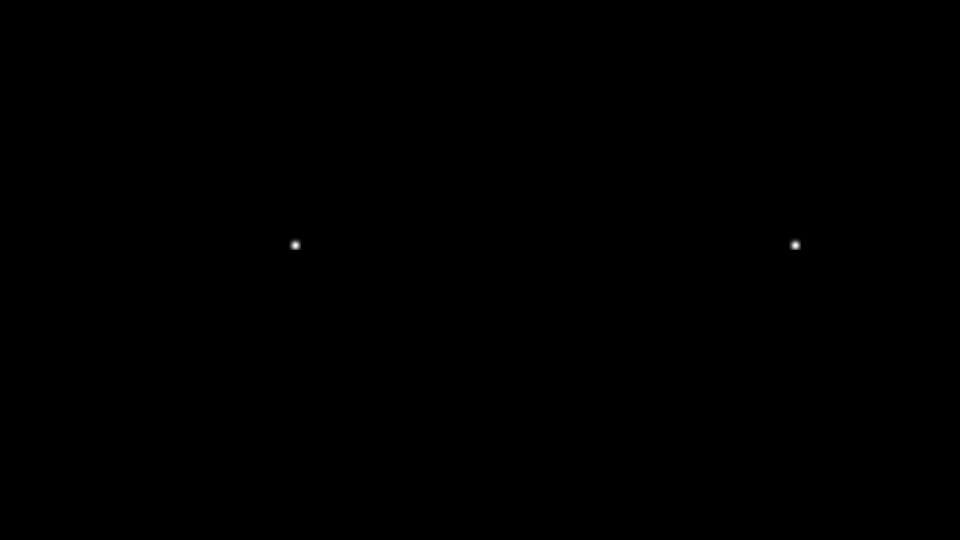

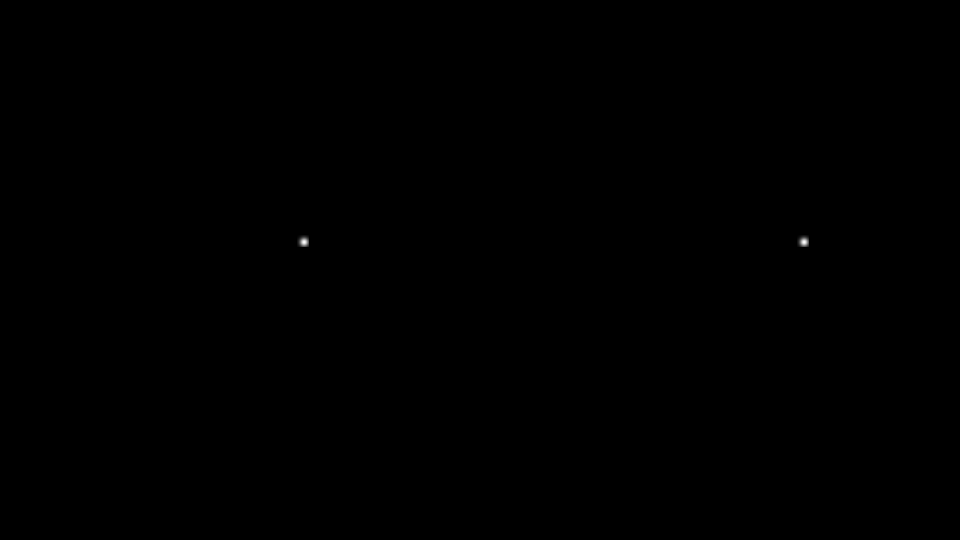

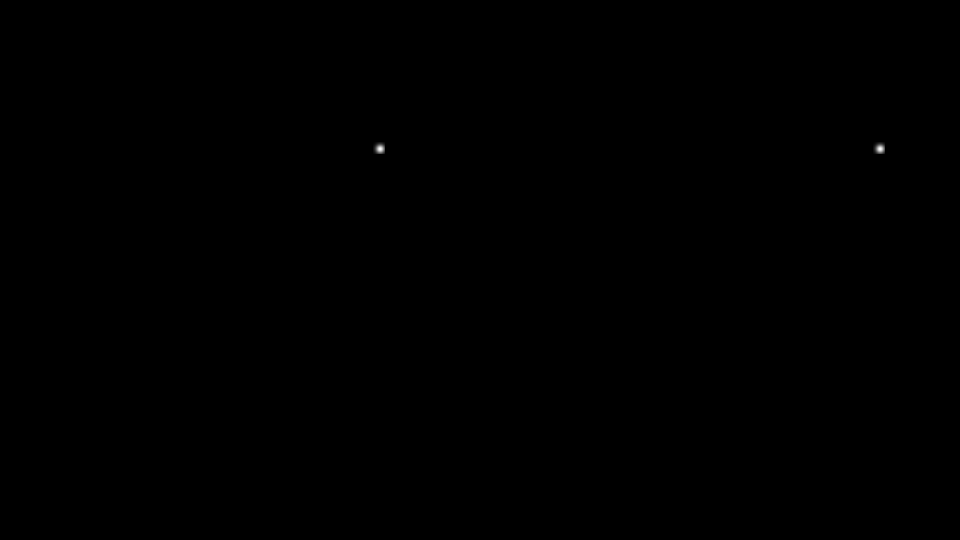

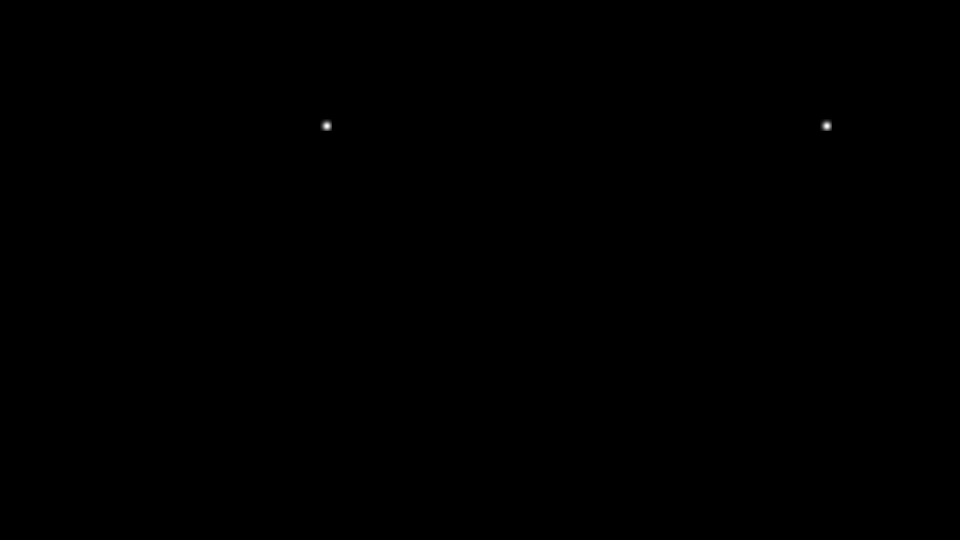

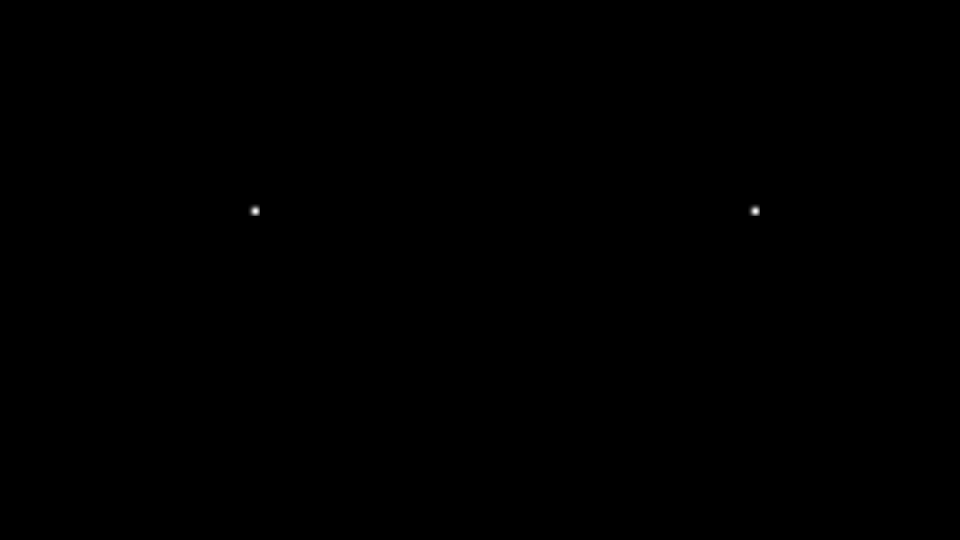

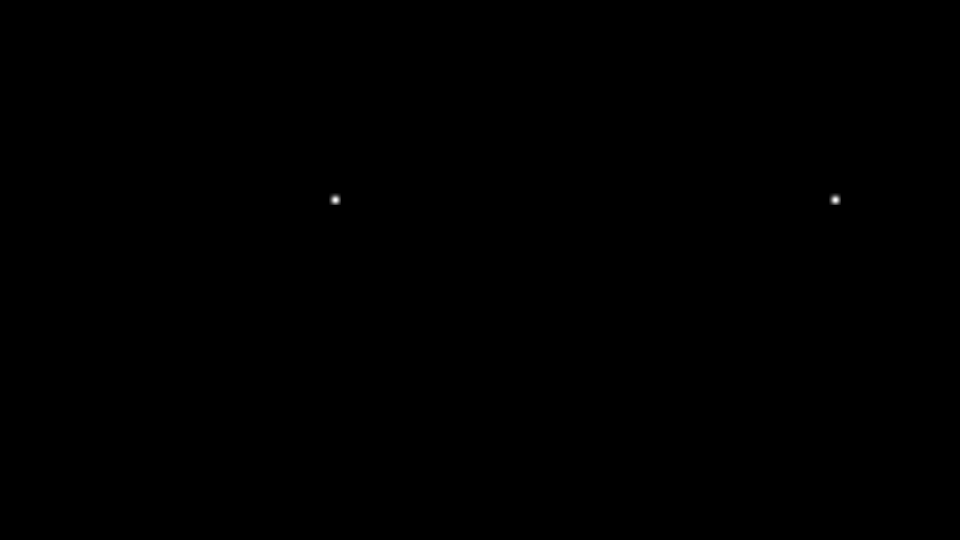

In [127]:
nbpoints = 9
# for point in keypoints:
#     print(point)
beliefsImg = CreateBeliefMap(image,keypoints_2d, nbpoints, sigma=3)
for i in range(nbpoints):
    display(beliefsImg[i])